In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm
import xscale as xsc
import xrft

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(15)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.34:33440 Dashboard: http://10.148.1.34:8787/status,Cluster Workers: 30 Cores: 120 Memory: 1500.00 GB


_________
# 1. Read dataset
## to compute geostrophic terms


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_Eta = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')
ds_us = xr.open_dataset(out_dir_zarr+'U_surface_rechunk.nc')
ds_vs = xr.open_dataset(out_dir_zarr+'V_surface_rechunk.nc')

ds = xr.merge([ds_Eta,ds_us,ds_vs,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
    depth    float64 0.5
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) fl

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}})
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center


In [7]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')

## 1.1 rspectra for total uv

In [42]:
time_chunk = 1883
chunks={'time': time_chunk, 'lat': 20, 'lon': 20} # time chunck: (2 months)

u_ij = gridx.interp(ds['U'],'X')   
u_ij = u_ij.chunk(chunks) 

v_ij = gridx.interp(ds['V'],'Y')   
v_ij = v_ij.chunk(chunks) 

uv = u_ij + 1j*v_ij
uv = np.real(uv).rename('uv')    
uv

<xarray.DataArray 'uv' (time: 9415, lat: 201, lon: 177)>
dask.array<shape=(9415, 201, 177), dtype=float32, chunksize=(1883, 20, 20)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [43]:
uv_fft_complex = xrft.dft(uv.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/time_chunk*3600
E_uv_blocks = E_uv_segments.mean(dim=['time_segment']) 
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
#E_uv_zonal_mean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(46.75, 50, 0.25), labels=np.arange(47, 50, 0.25)).mean(dim=['lat']))
E_uv = E_uv_blocks
E_uv = np.real(E_uv).rename('E_uv')
E_uv
#file_E = E_dir+'E_uv.zarr'
#%time E_uv.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv' (freq_time: 1883, lat: 201, lon: 177)>
dask.array<shape=(1883, 201, 177), dtype=float64, chunksize=(1883, 20, 20)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
  * lat                (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 ...
  * lon                (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...

In [44]:
E_uv_mean = E_uv.isel(lat=slice(20,180), lon=slice(20,150)).mean(dim=['lon','lat']) 
E_uv_mean = E_uv_mean.assign_coords(freq_cpd=E_uv_mean.freq_time * 86400.) 
print(E_uv_mean)

<xarray.DataArray 'E_uv' (freq_time: 1883)>
dask.array<shape=(1883,), dtype=float64, chunksize=(1883,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...


In [45]:
E_uv_mean.load()

<xarray.DataArray 'E_uv' (freq_time: 1883)>
array([1224.975215, 3296.598166, 2921.306925, ..., 2139.898655, 2921.306925,
       3296.598166])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...

# 2. Geostrophic terms

In [8]:
E_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/rspectra/'

In [17]:
dxgSSV_j = gridx.interp(ds.dxG * ds['V'],'Y') 
dxgSSV_ji = gridx.interp(dxgSSV_j,'X')    # SSV at (i_g,j)
Coriolis_u_linear = f_j * dxgSSV_ji /ds.dxC    #f*SSV
Coriolis_u_linear = np.real(Coriolis_u_linear).rename('Coriolis_u_linear')
Coriolis_u_linear = Coriolis_u_linear.chunk({'time': 1,'lat':201,'lon_g':177})
Coriolis_u_linear
Coriolis_u_linear.to_dataset().to_zarr(E_dir+'Coriolis_u_linear.zarr', mode='w')

In [18]:
dygSSU_i = gridx.interp(ds.dyG * ds['U'],'X') 
dxgSSU_ij = gridx.interp(dygSSU_i,'Y')    # SSU at (i,j_g)
Coriolis_v_linear = -f_i * dxgSSU_ij /ds.dyC    #-f*SSU
Coriolis_v_linear = np.real(Coriolis_v_linear).rename('Coriolis_v_linear')
Coriolis_v_linear = Coriolis_v_linear.chunk({'time': 1,'lat_g':201,'lon':177})
Coriolis_v_linear
Coriolis_v_linear.to_dataset().to_zarr(E_dir+'Coriolis_v_linear.zarr', mode='w')

In [19]:
g = 9.81
    
dB_dx_geo_raw = gridx.diff(g*ds['Eta'],'X')/ds.dxC    # d(Eta*g)/dx
dB_dy_geo_raw = gridx.diff(g*ds['Eta'],'Y')/ds.dyC    # d(Eta*g)/dy
    
# rotation
dB_dx_geo_raw_ij = gridx.interp(dB_dx_geo_raw,'X')
dB_dy_geo_raw_ij = gridx.interp(dB_dy_geo_raw,'Y')    

dB_dx_geo_raw_rotation =  dB_dx_geo_raw_ij*ds.CS - dB_dy_geo_raw_ij*ds.SN
dB_dy_geo_raw_rotation =  dB_dx_geo_raw_ij*ds.SN + dB_dy_geo_raw_ij*ds.CS

dB_dx_geo = gridx.interp(dB_dx_geo_raw_rotation,'X')
dB_dy_geo = gridx.interp(dB_dy_geo_raw_rotation,'Y')
        
dB_dx_geo = np.real(dB_dx_geo).rename('dB_dx_geo')    
dB_dx_geo = dB_dx_geo.chunk({'time': 1,'lat':201,'lon_g':177})
dB_dx_geo.to_dataset().to_zarr(E_dir+'dB_dx_geo.zarr', mode='w')
    
dB_dy_geo = np.real(dB_dy_geo).rename('dB_dy_geo')    
dB_dy_geo = dB_dy_geo.chunk({'time': 1,'lat_g':201,'lon':177})
dB_dy_geo.to_dataset().to_zarr(E_dir+'dB_dy_geo.zarr', mode='w')

_________
# 3. Read geostrophic components

In [9]:
E_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/rspectra/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_Coriolis_u_linear = xr.open_zarr(E_dir+'Coriolis_u_linear.zarr')
ds_Coriolis_v_linear = xr.open_zarr(E_dir+'Coriolis_v_linear.zarr')
ds_dB_dx_geo = xr.open_zarr(E_dir+'dB_dx_geo.zarr')
ds_dB_dy_geo = xr.open_zarr(E_dir+'dB_dy_geo.zarr')

ds_geo = xr.merge([ds_Coriolis_u_linear,ds_Coriolis_v_linear,ds_dB_dx_geo,ds_dB_dy_geo,grid])
print(ds_geo)
print('\n data size: %.1f GB' %(ds_geo.nbytes / 1e9))

<xarray.Dataset>
Dimensions:            (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
    depth              float64 0.5
    dxC                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * lat                (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 ...
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 ...
    rAw                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * time               (time) float64 0.0 0.04167 0.08333 0.125 0.1667 ...
    dxG                (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyC                (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * lat_g              (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 ...
  * lon                (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 ..

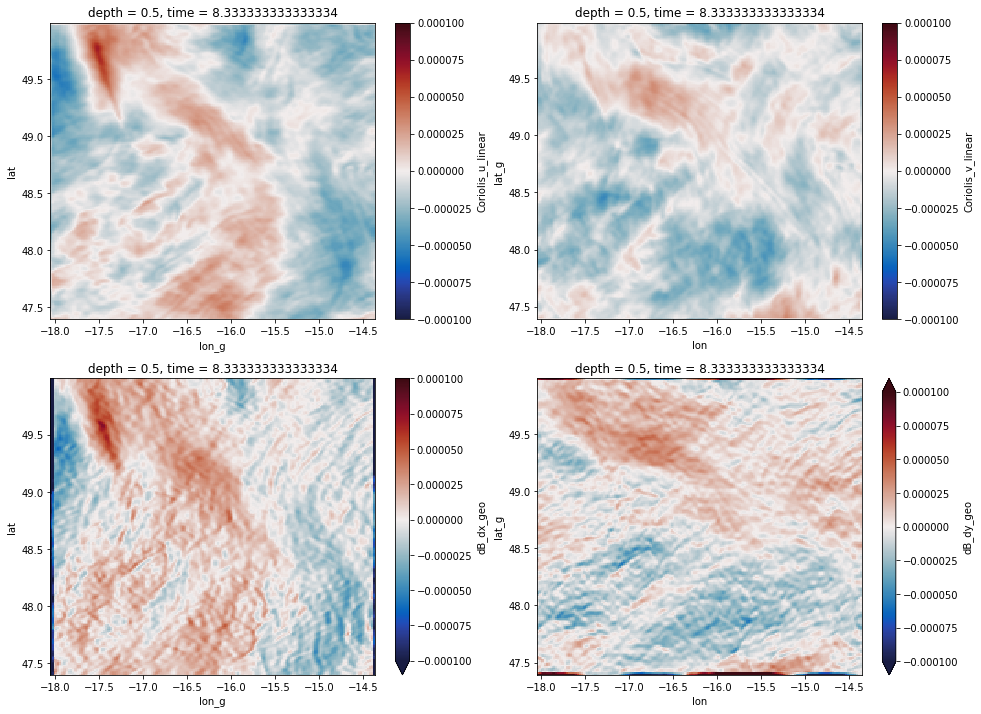

In [11]:
fig = plt.figure(figsize = (16,12))

plt.subplot(221)
ds_geo.Coriolis_u_linear.isel(time=200).plot(vmin=-1*10e-5, vmax=1*10e-5, cmap = cm.balance)

plt.subplot(222)
ds_geo.Coriolis_v_linear.isel(time=200).plot(vmin=-1*10e-5, vmax=1*10e-5, cmap = cm.balance)

plt.subplot(223)
ds_geo.dB_dx_geo.isel(time=200).plot(vmin=-1*10e-5, vmax=1*10e-5, cmap = cm.balance)

plt.subplot(224)
ds_geo.dB_dy_geo.isel(time=200).plot(vmin=-1*10e-5, vmax=1*10e-5, cmap = cm.balance)

## 3.1 Geostrophic velocity

In [10]:
vg = (ds_geo.dB_dx_geo)/f_j
ug = (-ds_geo.dB_dy_geo)/f_i

time_chunk = 1883
chunks={'time': time_chunk, 'lat': 20, 'lon': 20} # time chunck: (2 months)

ug_ij = gridx.interp(ug,'Y')   
ug_ij = ug_ij.chunk(chunks) 

vg_ij = gridx.interp(vg,'X')   
vg_ij = vg_ij.chunk(chunks) 

uv_g = ug_ij + 1j*vg_ij
uv_g = np.real(uv_g).rename('uv_g')   
uv_g

<xarray.DataArray 'uv_g' (time: 9415, lat: 201, lon: 177)>
dask.array<shape=(9415, 201, 177), dtype=float32, chunksize=(1883, 20, 20)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [21]:
time_chunk = 1883

uv_fft_complex = xrft.dft(uv_g.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/time_chunk*3600
E_uv_blocks = E_uv_segments.mean(dim=['time_segment']) 
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
#E_uv_zonal_mean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(46.75, 50, 0.25), labels=np.arange(47, 50, 0.25)).mean(dim=['lat']))

E_geo = E_uv_blocks
E_geo = np.real(E_geo).rename('E_geo')
E_geo
#file_E = E_dir+'E_drifter_raw.zarr'
#%time E_drifter_raw.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_geo' (freq_time: 1883, lat: 201, lon: 177)>
dask.array<shape=(1883, 201, 177), dtype=float64, chunksize=(1883, 20, 20)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
  * lat                (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 ...
  * lon                (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...

In [29]:
E_geo_mean = E_geo.isel(lat=slice(20,180), lon=slice(20,150)).mean(dim=['lon','lat']) 
E_geo_mean = E_geo_mean.assign_coords(freq_cpd=E_geo_mean.freq_time * 86400.) 
print(E_geo_mean)

<xarray.DataArray 'E_geo' (freq_time: 1883)>
dask.array<shape=(1883,), dtype=float64, chunksize=(1883,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...


In [30]:
E_geo_mean.load()

<xarray.DataArray 'E_geo' (freq_time: 1883)>
array([1595.541861, 3953.687351, 2434.538596, ..., 1419.874337, 2434.538596,
       3953.687351])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...

## 3.2 Ageostrophic velocity

In [12]:
va = (ds_geo.Coriolis_u_linear - ds_geo.dB_dx_geo)/f_j
ua = (-ds_geo.Coriolis_v_linear + ds_geo.dB_dy_geo)/f_i

In [116]:
ua = np.real(ua).rename('ua')    
ua = ua.chunk({'time': 1,'lat_g':201,'lon':177})
ua.to_dataset().to_zarr(E_dir+'ua.zarr', mode='w')

In [39]:
va = np.real(va).rename('va')    
va = va.chunk({'time': 1,'lat':201,'lon_g':177})
va.to_dataset().to_zarr(E_dir+'va.zarr', mode='w')

## 3.2.1 Rotary spectra for ageostrophic velocity

In [31]:
ds_u = xr.open_zarr(E_dir+'ua.zarr')#.rename({'lat_g': 'lat'})
ds_v = xr.open_zarr(E_dir+'va.zarr')#.rename({'lon_g': 'lon'})
ds_uv = xr.merge([ds_u,ds_v,grid])
ds_uv

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
    depth    float64 0.5
    dxG      (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyC      (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 47.45 47.46 47.48 47.49 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
    rAs      (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    dxC      (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG      (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 -17.94 -17.92 ...
    rAw      (lat, lon_g) float32 dask.array<shape=(201

In [32]:
time_chunk = 1883
chunks={'time': time_chunk, 'lat': 20, 'lon': 20} # time chunck: (2 months)

In [33]:
ua_ij = gridx.interp(ds_uv['ua'],'Y')   
ua_ij = ua_ij.chunk(chunks) 
ua_ij

<xarray.DataArray 'mul-2b2eef83fc64a5819d4420103e16a177' (lat: 201, lon: 177, time: 9415)>
dask.array<shape=(201, 177, 9415), dtype=float32, chunksize=(20, 20, 1883)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

In [34]:
va_ij = gridx.interp(ds_uv['va'],'X')   
va_ij = va_ij.chunk(chunks) 
va_ij

<xarray.DataArray 'mul-67f489d7d58c06b4698d8ecc1026503b' (lat: 201, lon: 177, time: 9415)>
dask.array<shape=(201, 177, 9415), dtype=float32, chunksize=(20, 20, 1883)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

In [35]:
uv_a = ua_ij + 1j*va_ij
uv_a = np.real(uv_a).rename('uv_a')   
uv_a

<xarray.DataArray 'uv_a' (lat: 201, lon: 177, time: 9415)>
dask.array<shape=(201, 177, 9415), dtype=float32, chunksize=(20, 20, 1883)>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...

In [36]:
uv_a = ua_ij + 1j*va_ij
uv_a = np.real(uv_a).rename('uv_a')    
uv_a = uv_a.chunk({'time': 1883,'lat':201,'lon':177})
uv_a
uv_a.to_dataset().to_netcdf(E_dir+'uv_a.nc', mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 13.13 MB detected in task graph: 
  ("('rechunk-merge-eb04c408791a7e4fd038304711a8f90f ... 43e3>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


_________
## 3.3.2 Rotary spectra of ageostrophic uv

In [37]:
ds_uv_a = xr.open_dataset(E_dir+'uv_a.nc')#.chunk({'time': 1883,'lat':201,'lon':177})
ds_uv_a

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    uv_a     (lat, lon, time) float32 ...

In [38]:
time_chunk = 1883

uv_fft_complex = xrft.dft(uv_a.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/time_chunk*3600
E_uv_blocks = E_uv_segments.mean(dim=['time_segment']) 
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
#E_uv_zonal_mean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(46.75, 50, 0.25), labels=np.arange(47, 50, 0.25)).mean(dim=['lat']))

E_ageo = E_uv_blocks
E_ageo = np.real(E_ageo).rename('E_ageo')
E_ageo
#file_E = E_dir+'E_drifter_raw.zarr'
#%time E_drifter_raw.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_ageo' (lat: 201, lon: 177, freq_time: 1883)>
dask.array<shape=(201, 177, 1883), dtype=float64, chunksize=(201, 177, 1883)>
Coordinates:
  * lat                (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 ...
  * lon                (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 ...
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...

In [39]:
E_ageo_mean = E_ageo.isel(lat=slice(20,180), lon=slice(20,150)).mean(dim=['lon','lat']) 
E_ageo_mean = E_ageo_mean.assign_coords(freq_cpd=E_ageo_mean.freq_time * 86400.) 
print(E_ageo_mean)

<xarray.DataArray 'E_ageo' (freq_time: 1883)>
dask.array<shape=(1883,), dtype=float64, chunksize=(1883,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...


In [41]:
E_ageo_mean.load()

<xarray.DataArray 'E_ageo' (freq_time: 1883)>
array([195.107335, 650.84509 , 568.5246  , ..., 557.264765, 568.5246  ,
       650.84509 ])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01275 0.02549 0.03824 ...
    freq_time_spacing  float64 0.01275
    freq_cpd           (freq_time) float64 0.0 1.101e+03 2.202e+03 3.304e+03 ...

# Figure together

Text(0.5,1,'')

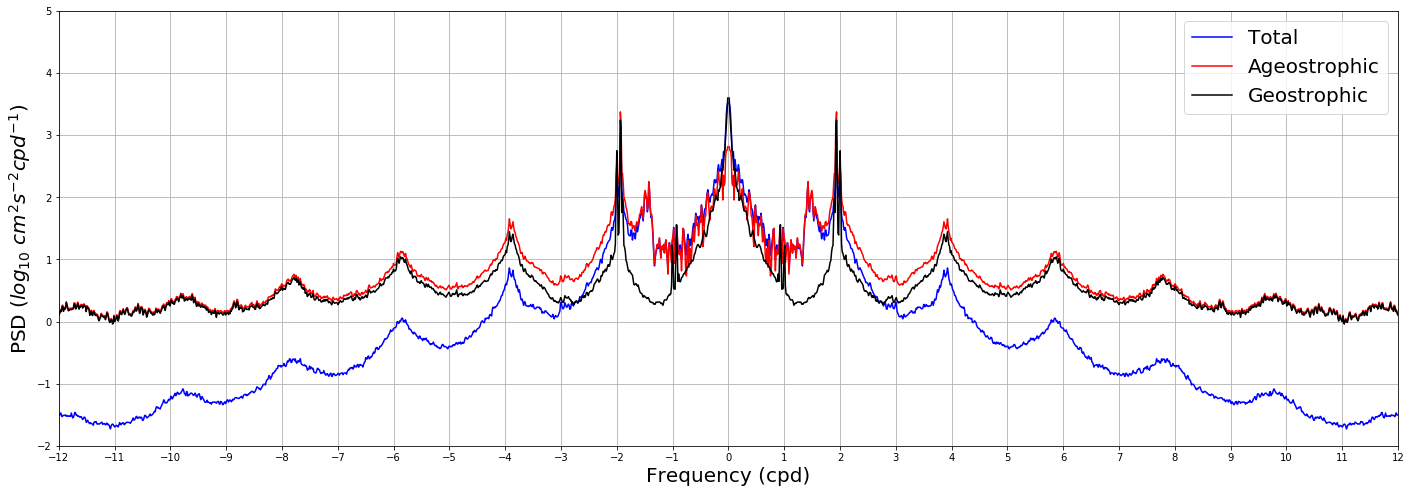

In [50]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Total', 'Ageostrophic', 'Geostrophic']

# total uv
(np.log10(E_uv_mean).where(E_uv_mean.freq_time>0)).plot(ax=ax,color='blue', label=labels[0])
(np.log10(E_uv_mean).where(E_uv_mean.freq_time<0)).plot(ax=ax,color='blue')

# ageostrophic
(np.log10(E_ageo_mean).where(E_ageo_mean.freq_time>0)).plot(ax=ax,color='red', label=labels[1])
(np.log10(E_ageo_mean).where(E_ageo_mean.freq_time<0)).plot(ax=ax,color='red')

# geostrophic
(np.log10(E_geo_mean).where(E_geo_mean.freq_time>0)).plot(ax=ax,color='black', label=labels[2])
(np.log10(E_geo_mean).where(E_geo_mean.freq_time<0)).plot(ax=ax,color='black')

ax.set_xlim([-12.,12.])
ax.set_ylim([-2.,5.])
ax.set_xticks([-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks([-2.,-1.,0.,1.,2.,3.,4.,5.])

ax.legend(prop={'size': 20}); ax.grid()
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=20)
ax.set_xlabel('Frequency (cpd)',fontsize=20)
ax.set_title('',fontsize=24)

Text(0.5,1,'')

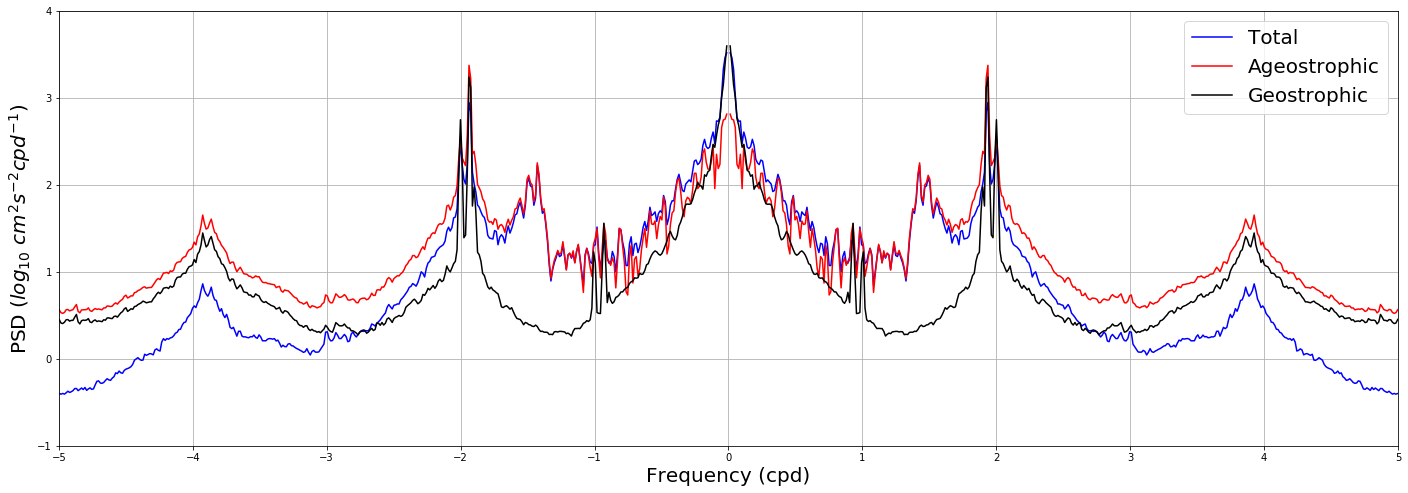

In [51]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Total', 'Ageostrophic', 'Geostrophic']

# total uv
(np.log10(E_uv_mean).where(E_uv_mean.freq_time>0)).plot(ax=ax,color='blue', label=labels[0])
(np.log10(E_uv_mean).where(E_uv_mean.freq_time<0)).plot(ax=ax,color='blue')

# ageostrophic
(np.log10(E_ageo_mean).where(E_ageo_mean.freq_time>0)).plot(ax=ax,color='red', label=labels[1])
(np.log10(E_ageo_mean).where(E_ageo_mean.freq_time<0)).plot(ax=ax,color='red')

# geostrophic
(np.log10(E_geo_mean).where(E_geo_mean.freq_time>0)).plot(ax=ax,color='black', label=labels[2])
(np.log10(E_geo_mean).where(E_geo_mean.freq_time<0)).plot(ax=ax,color='black')

ax.set_xlim([-5.,5.])
ax.set_ylim([-1.,4.])
ax.set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
ax.set_yticks([-1.,0.,1.,2.,3.,4.])

ax.legend(prop={'size': 20}); ax.grid()
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=20)
ax.set_xlabel('Frequency (cpd)',fontsize=20)
ax.set_title('',fontsize=24)

Text(0.5,1,'V_a + V_g')

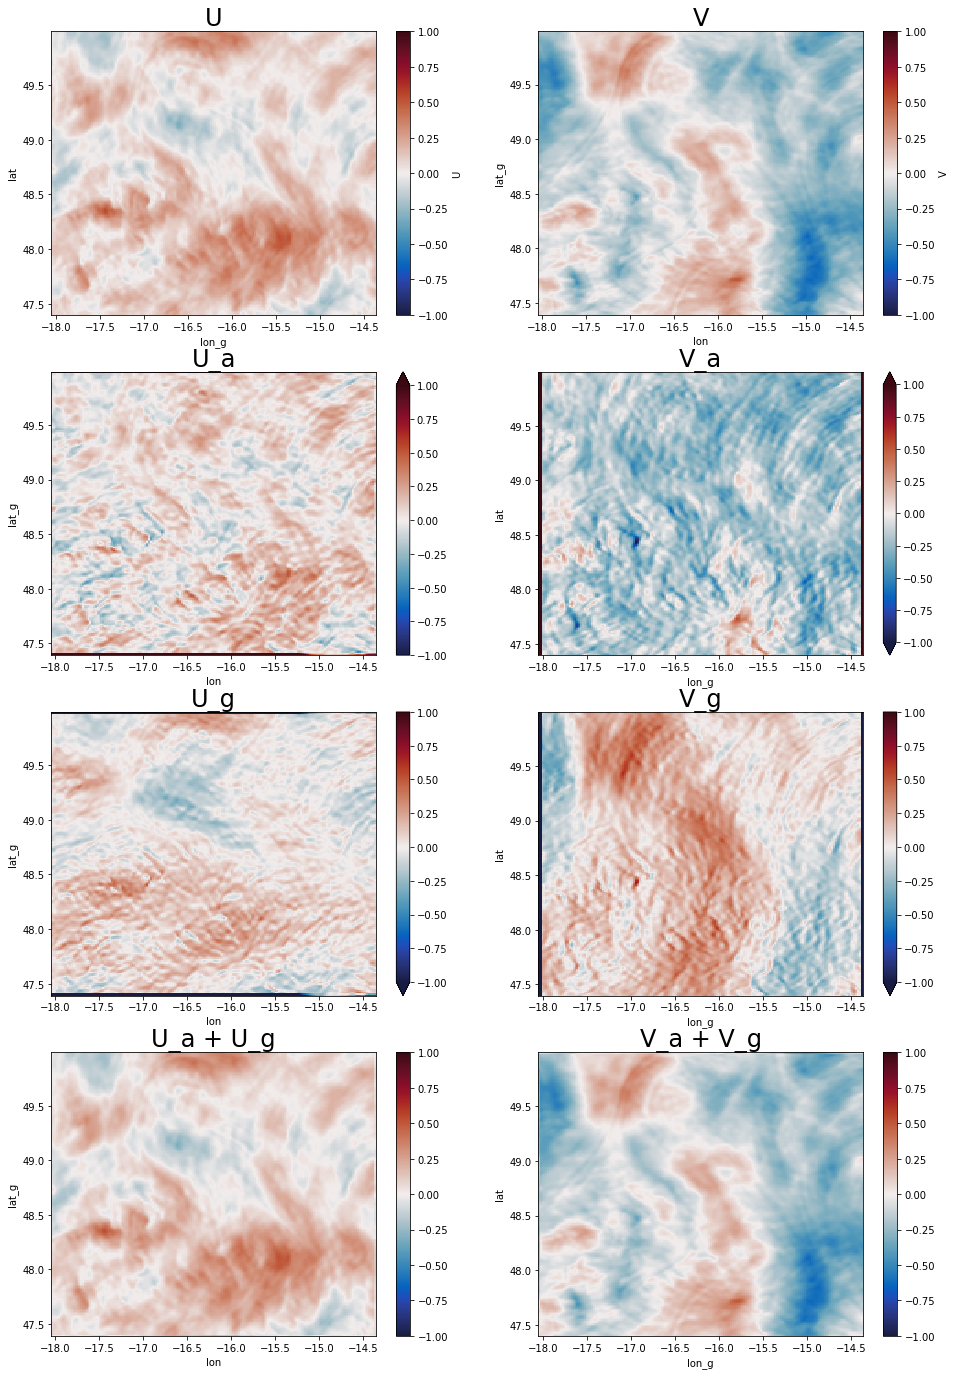

In [54]:
time_pick = 100

fig, ax = plt.subplots(figsize=(16,24))

ax = plt.subplot(421)
ds.U.isel(time=time_pick).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('U',fontsize=24)

ax = plt.subplot(422)
ds.V.isel(time=time_pick).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('V',fontsize=24)

ax = plt.subplot(423)
ua.isel(time=time_pick).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('U_a',fontsize=24)

ax = plt.subplot(424)
va.isel(time=time_pick).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('V_a',fontsize=24)

ax = plt.subplot(425)
ug.isel(time=time_pick).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('U_g',fontsize=24)

ax = plt.subplot(426)
vg.isel(time=time_pick).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('V_g',fontsize=24)

ax = plt.subplot(427)
(ug.isel(time=time_pick) + ua.isel(time=time_pick)).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('U_a + U_g',fontsize=24)

ax = plt.subplot(428)
(vg.isel(time=time_pick) + va.isel(time=time_pick)).plot(vmin=-1, vmax=1, cmap = cm.balance)
ax.set_title('V_a + V_g',fontsize=24)


In [56]:
cluster.scheduler.close()

<Future finished result=None>